# Mini-projet : Classification de tumeurs gliales

Les _gliomes_ ou _tumeurs gliales_ sont des tumeurs du glie, le tissu de soutien neuronal du cerveau. Elles sont classifiées en 4 grades anatomo-pathologiques, dont dépend la prise en charge.

Dans ce jeu de données, chaque observation est un gliome, décrit par l'expression de 4 434 gènes. L'expression d'un gène est une mesure de la quantité d'ARN correspondant à ce gène qui est présente dans la cellule. Schématiquement, l'ADN est transcrit en ARN, lequel est lui-même traduit en une protéine. Les protéines assurent une multitude de fonctions du vivant, mais mesurer leur quantité est difficile ; d'où l'intérêt d'utiliser les quantités d'ARN, bien que la correspondance ne soit pas immédiate. 

Chaque gliome de notre jeu de données est étiquetée en fonction de son grade. 

Le but de ce projet est de construire un classifieur qui détermine, sur la base de l'expression de ces 4 434 gènes, le grade d'un gliome.

## Instructions
1. Comparez les performances d'au moins deux algorithmes d'apprentissage sur ce problème de classification.

__Attention :__
* au _data leakage_ (ne pas utiliser les données sur lesquelles on évalue les modèles pour les entraîner ou prétraiter les données)
* à la taille du jeu de données
* au nombre de classes
* à choisir une mesure de performance appropriée (justifiez votre choix)
2. Identifiez, quand cela est possible, les gènes les plus importants pour les modèles que vous avez entraînés. S'agit-il des mêmes gènes
* entre deux modèles obtenus grâce à un algorithme d'apprentissage différents ?
* entre deux modèles obtenus en utilisant le même algorithme d'apprentissage sur des sous-échantillons différents des données ?

N'oubliez pas de commenter et interpréter vos résultats.

## Chargement des données

In [1]:
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

data_matrix = scipy.io.loadmat("gliome.mat")

In [2]:
X = data_matrix['X']
print(X.shape)

(50, 4434)


In [3]:
y = data_matrix['Y'][:, 0] 
print(y.shape)

(50,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.3, random_state=84, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(35, 4434) (15, 4434) (35,) (15,)


In [5]:
for ligne in X_train:
    #vérification des données manquantes :
    if any([not float(val) for val in ligne]):
        print(ligne)
print()
print(y)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4]


<class 'numpy.ndarray'>
35


Text(0.5, 0, 'train labels')

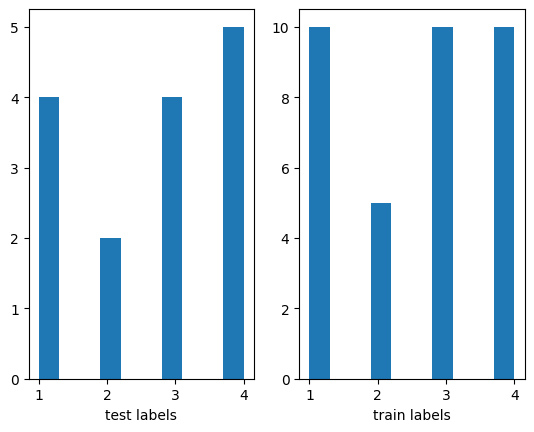

In [6]:
print(type(y_train))
print(len(y_train))

plt.subplot(1, 2, 1)
plt.hist(y_test)
plt.xlabel('test labels')
plt.subplot(1, 2, 2)
plt.hist(y_train)
plt.xlabel('train labels')

We here remark that while having few data, we also have one class that is under-represented.

# PCA

(-2.6298240070410395, 3.270175992958966)

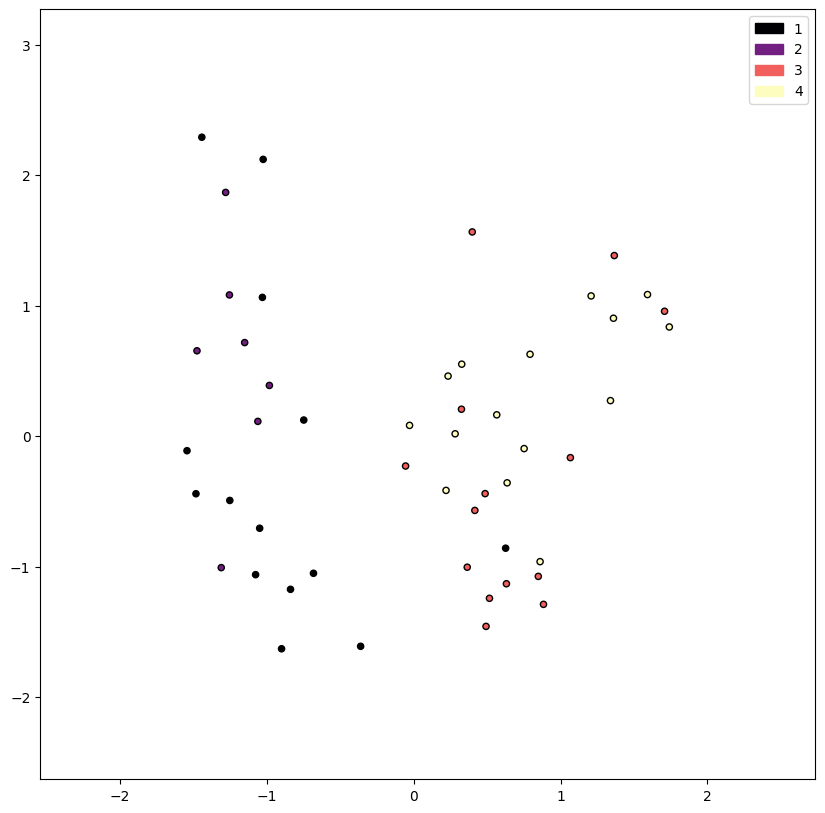

In [20]:
# We compute the first 2 PCA componants of the original dataset, and then project each example on this 2D space
pca_pip = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=2, whiten=True))])
X_pca = pca_pip.fit_transform(X)

h = .02  # Defines the grid resolution
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
cmap = plt.cm.get_cmap('magma', 4)
plt.figure(figsize=(10,10))
plt.legend([mpatches.Patch(color=cmap(l)) for l in range(4)], [str(l) for l in range(1,5)])

sample = np.arange(50)
plt.scatter(X_pca[sample, 0], X_pca[sample, 1], c=y[sample], cmap='magma', edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

Here we can see with the PCA algorithm that classes 1 and 2 are fairly easy to separate from classes 3 and 4. Thus we sould be able to see a distinction between these two set of classes

In [32]:
pca_components = pca_pip['pca'].components_
print(pca_components)
print()
print("The max coefficient in pca's x axis", max(enumerate(pca_components[0]), key = lambda component : component[1]))
print("The max coefficient in pca's y axis", max(enumerate(pca_components[1]), key = lambda component : component[1]))

[[-0.01813358 -0.00621113 -0.01191165 ...  0.00491147  0.00161466
  -0.0176488 ]
 [ 0.01221947 -0.01326224 -0.0058364  ...  0.01777626  0.01443474
   0.02049674]]

The max coefficient in pca's x axis (4431, 0.004911471027244287)
The max coefficient in pca's y axis (21, 0.03690814669057248)


**Classification with a simple tree**

[Text(0.5, 0.8333333333333334, 'X[118] <= 3.203\nentropy = 1.95\nsamples = 35\nvalue = [10, 5, 10, 10]'),
 Text(0.25, 0.5, 'X[3044] <= 2.229\nentropy = 1.0\nsamples = 20\nvalue = [0, 0, 10, 10]'),
 Text(0.125, 0.16666666666666666, 'entropy = 0.0\nsamples = 10\nvalue = [0, 0, 0, 10]'),
 Text(0.375, 0.16666666666666666, 'entropy = 0.0\nsamples = 10\nvalue = [0, 0, 10, 0]'),
 Text(0.75, 0.5, 'X[1149] <= 2.964\nentropy = 0.918\nsamples = 15\nvalue = [10, 5, 0, 0]'),
 Text(0.625, 0.16666666666666666, 'entropy = 0.0\nsamples = 10\nvalue = [10, 0, 0, 0]'),
 Text(0.875, 0.16666666666666666, 'entropy = 0.0\nsamples = 5\nvalue = [0, 5, 0, 0]')]

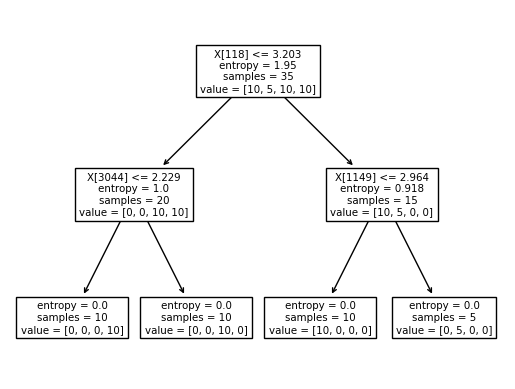

In [33]:
clf = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=2, 
                                  min_samples_split=2, min_samples_leaf=1, 
                                  min_weight_fraction_leaf=0.0, max_features=None, 
                                  random_state=None, max_leaf_nodes=None, 
                                  min_impurity_decrease=1e-07, class_weight=None)
clf = clf.fit(X_train, y_train)

# Graphical view of learnt Decision Tree
tree.plot_tree(clf)

Let's display the results of the training on the test set

In [11]:
print(clf)
score = clf.score(X_test, y_test)
print("Acuracy (on test set) = ", score)
y_true, y_pred = y_test, clf.predict(X_test)
print( classification_report(y_true, y_pred) )
print("\n CONFUSION MATRIX")
print( confusion_matrix(y_true, y_pred) )

DecisionTreeClassifier(criterion='entropy', max_depth=5,
                       min_impurity_decrease=1e-07)
Acuracy (on test set) =  0.7333333333333333
              precision    recall  f1-score   support

           1       0.75      0.75      0.75         4
           2       0.50      0.50      0.50         2
           3       1.00      0.50      0.67         4
           4       0.71      1.00      0.83         5

    accuracy                           0.73        15
   macro avg       0.74      0.69      0.69        15
weighted avg       0.77      0.73      0.72        15


 CONFUSION MATRIX
[[3 1 0 0]
 [1 1 0 0]
 [0 0 2 2]
 [0 0 0 5]]


Let's try to optimize the hyper parameters with using cross validation

In [12]:
param_grid = [
  {'criterion': ['entropy', 'log_loss', 'gini'],
   'max_depth': [2, 3, 4, 5, 6], 
   'min_samples_split':[2, 3, 4, 5]}
 ]
print(param_grid)

# Cross-validation grid-search (for finding best possible f1 score)
clf = GridSearchCV( tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=5, 
                                  min_samples_split=4, min_samples_leaf=1, 
                                  min_weight_fraction_leaf=0.0, max_features=None, 
                                  random_state=None, max_leaf_nodes=None, 
                                  min_impurity_decrease=1e-07, class_weight=None), 
                   param_grid, cv=3, scoring='accuracy') 
    
clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
           % (mean, std * 2, params))
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

[{'criterion': ['entropy', 'log_loss', 'gini'], 'max_depth': [2, 3, 4, 5, 6], 'min_samples_split': [2, 3, 4, 5]}]


Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 2}

Grid scores on development set:

0.747 (+/-0.266) for {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 2}
0.573 (+/-0.223) for {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 3}
0.634 (+/-0.331) for {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 4}
0.571 (+/-0.274) for {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 5}
0.687 (+/-0.278) for {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}
0.520 (+/-0.323) for {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 3}
0.601 (+/-0.145) for {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 4}
0.573 (+/-0.112) for {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5}
0.657 (+/-0.139) for {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2}
0.629 (+/-0.069) for {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split

A simple tree have already some good results (the acuracy is 0.778 for the best set of hyper parameters) but we could try to improve it by using random forest and diminishing the noise

Now let's use random forest and see the results

In [13]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=5,
                             min_samples_split=2, min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_leaf_nodes=None, min_impurity_decrease=1e-07, bootstrap=True, 
                             oob_score=False, n_jobs=1, random_state=None, 
                             verbose=0, warm_start=False, class_weight=None)
clf = clf.fit(X_train, y_train)
print("n_estimators=", clf.n_estimators, " max_depth=",clf.max_depth,
      "max_features=", clf.max_features)

# Evaluate acuracy on test data
print(clf)
score = clf.score(X_test, y_test)
print("Acuracy (on test set) = ", score)
y_true, y_pred = y_test, clf.predict(X_test)
print( classification_report(y_true, y_pred) )
print("\n CONFUSION MATRIX")
print( confusion_matrix(y_true, y_pred) )

n_estimators= 100  max_depth= 5 max_features= sqrt
RandomForestClassifier(max_depth=5, min_impurity_decrease=1e-07, n_jobs=1)
Acuracy (on test set) =  0.7333333333333333
              precision    recall  f1-score   support

           1       0.80      1.00      0.89         4
           2       1.00      0.50      0.67         2
           3       0.60      0.75      0.67         4
           4       0.75      0.60      0.67         5

    accuracy                           0.73        15
   macro avg       0.79      0.71      0.72        15
weighted avg       0.76      0.73      0.73        15


 CONFUSION MATRIX
[[4 0 0 0]
 [1 1 0 0]
 [0 0 3 1]
 [0 0 2 3]]


Again we are using cross validation to find the best couples of hyper parameters

In [14]:
param_grid = [
  {'n_estimators': [20,50,100,150,200,250,500], 
   'max_features':["sqrt", "log2"],
   'max_depth': [2, 3, 4, 5,]}
 ]
print(param_grid)

# Cross-validation grid-search (for finding best possible accuracy)
clf = GridSearchCV(RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None,
                             min_samples_split=2, min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_leaf_nodes=None, min_impurity_decrease=1e-07, bootstrap=True, 
                             oob_score=False, n_jobs=1, random_state=None, 
                             verbose=0, warm_start=False, class_weight=None), 
                   param_grid, cv=3, scoring='balanced_accuracy') 
    
clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Balanced acuracy (on best params) = ", clf.best_score_)

y_true, y_pred = y_test, clf.predict(X_test)
print("\n CONFUSION MATRIX")
print( confusion_matrix(y_true, y_pred) )
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
           % (mean, std * 2, params))
print()

[{'n_estimators': [20, 50, 100, 150, 200, 250, 500], 'max_features': ['sqrt', 'log2'], 'max_depth': [2, 3, 4, 5]}]


Best parameters set found on development set:

{'max_depth': 3, 'max_features': 'log2', 'n_estimators': 50}

Balanced acuracy (on best params) =  0.8541666666666666

 CONFUSION MATRIX
[[3 1 0 0]
 [1 1 0 0]
 [0 0 2 2]
 [0 0 1 4]]

Grid scores on development set:

0.562 (+/-0.266) for {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 20}
0.611 (+/-0.137) for {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 50}
0.639 (+/-0.137) for {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 100}
0.660 (+/-0.079) for {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 150}
0.694 (+/-0.347) for {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 200}
0.632 (+/-0.079) for {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 250}
0.660 (+/-0.079) for {'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 500}
0.528 (+/-0.137) for {'max_depth': 2, 'max_features': 'log2', 'n_estimators': 20}
0.715 (+/-0.314) for {'max_depth': 2, 'max_features': 'log2', 'n_estimators'

We obtain a pretty good result with a balanced acuracy of 85% on the set {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 200} and the confusion matrix appears to be quite fine. The first and the last class seems to be well predicted while the other two have some issues. It also appears that data seems separable in 2 classes (confirm by the kmeans part, where the class 1 and 2 form a class and the 3 and 4 another one) but the distinction inside is more difficult. The results we obtain are good but the lack of data is a real problem to have more precise results.

**Discussion of the metric used**

By default we used the acuracy but we managed to see that the second class was often misclassified. We suspect the few amount of data concerning this class to be the main issue. The accuracy can actually be a misleading information when dealing with unbalanced amount of data for each class. We then try to find a way to skirt the problem by using the 'balanced acuracy' metrics.

# Logistic Regression

Because we have a small amount of data in the problem, one idea would be to use a linear model, such as logistic regression. Plus, this model (in contrary to kNN or MLP for classification) is fairly simple to understand, and to extract informations such as which gene is important.

In [37]:
from sklearn.linear_model import LogisticRegression


param_grid = [
  {'lreg__C': [.0001,.001,.003,.01]}
 ]
print(param_grid)

# Cross-validation grid-search (for finding best possible accuracy)
clf = GridSearchCV( Pipeline([('scaler', StandardScaler()), ('lreg', LogisticRegression(penalty='l2', C=2, max_iter=200))]), 
                   param_grid, cv=3, scoring='balanced_accuracy') 
# NOTE THAT YOU CAN USE OTHER VALUE FOR cv (# of folds) and OTHER SCORING CRITERIA OTHER THAN 'accuracy'
    
clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
           % (mean, std * 2, params))
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()


[{'lreg__C': [0.0001, 0.001, 0.003, 0.01]}]


Best parameters set found on development set:

{'lreg__C': 0.001}

Grid scores on development set:

0.618 (+/-0.119) for {'lreg__C': 0.0001}
0.840 (+/-0.142) for {'lreg__C': 0.001}
0.840 (+/-0.142) for {'lreg__C': 0.003}
0.840 (+/-0.142) for {'lreg__C': 0.01}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           1       0.80      1.00      0.89         4
           2       1.00      0.50      0.67         2
           3       1.00      0.50      0.67         4
           4       0.71      1.00      0.83         5

    accuracy                           0.80        15
   macro avg       0.88      0.75      0.76        15
weighted avg       0.85      0.80      0.78        15




The parameter that did the best in cross validation was C = 0.001, let's search for the main composants :

In [34]:
pip = Pipeline([('scaler', StandardScaler()), ('lreg', LogisticRegression(penalty='l2', C=0.001, max_iter=200))])
pip.fit(X_train, y_train)
preds_regularised_logistic_regression = pip.predict(X_test) 

# Obtention des coefficients de la régression logistique
logistic_regression = pip.named_steps['lreg']
coefficients = logistic_regression.coef_[0]

print("CONFUSION MATRIX")
print( metrics.confusion_matrix(y_true=y_test, y_pred=preds_regularised_logistic_regression) )
most_important_coeffs = sorted([(i,abs(coefficient)) for i, coefficient in enumerate(coefficients)], key=lambda x: x[1], reverse=True)
print('\nThe most important genes for logistic regression are :')
for i, coeff in most_important_coeffs[:3]:
    print(i)

print()
print('Position of most important genes in PCA :')
for index, (i, coeff) in enumerate(most_important_coeffs):
    if i == 4431:
        print(f"4431 is in position {index}")
    if i == 21:
        print(f"21 is in position {index}")

print()
print('Position of most important genes in Random Tree :')
for index, (i, coeff) in enumerate(most_important_coeffs):
    if i == 3203:
        print(f"3203 is in position {index}")
    if i == 2229:
        print(f"2229 is in position {index}")
    if i == 2964:
        print(f"2964 is in position {index}")

CONFUSION MATRIX
[[4 0 0 0]
 [1 1 0 0]
 [0 0 2 2]
 [0 0 0 5]]

The most important genes are :
11
449
1074

Position of most important genes in PCA :
4431 is in position 3483
21 is in position 3785

Position of most important genes in Random Tree :
2229 is in position 1515
3203 is in position 2693
2964 is in position 3615


Here we can see that the most important genes are 11, 449 and 1074. And the main composants our random forest used to classify the data are not very important for the logistic regression algorithm (3843 is in position 1287, 3044 ...), yet are in better positions that the main components of pca decomposition. We can't interpret these positions as importance of the coefficients. We then must use all the genes to classify the values.

We now try to find the important genes of Logistic Regression and simple Tree inside the PCA coefficient, to figure if any gene used for classifying has a good variance (meaning the values take on an important scale, and we have a lot of precision).

In [36]:
most_important_coeffs_x = sorted([(i,abs(coefficient)) for i, coefficient in enumerate(pca_components[0])], key=lambda x: x[1], reverse=True)
most_important_coeffs_y = sorted([(i,abs(coefficient)) for i, coefficient in enumerate(pca_components[1])], key=lambda x: x[1], reverse=True)

print('\nThe most important genes for PCA are :')
print('For x axis')
for i, coeff in most_important_coeffs_x[:3]:
    print(i)
print('For y axis')
for i, coeff in most_important_coeffs_y[:3]:
    print(i)

print()
print()
print('Position of most important genes in Logistic Regression :')
for index, (i, coeff) in enumerate(most_important_coeffs_x):
    if i == 4431:
        print(f"4431 is in position {index} for the x axis of pca")
    if i == 21:
        print(f"21 is in position {index} for the x axis of pca")
print('----')
for index, (i, coeff) in enumerate(most_important_coeffs_y):
    if i == 4431:
        print(f"4431 is in position {index} for the y axis of pca")
    if i == 21:
        print(f"21 is in position {index} for the y axis of pca")

print()
print()
print('Position of most important genes in Random Tree :')
for index, (i, coeff) in enumerate(most_important_coeffs_x):
    if i == 3203:
        print(f"3203 is in position {index} for the x axis of pca")
    if i == 2229:
        print(f"2229 is in position {index} for the x axis of pca")
    if i == 2964:
        print(f"2964 is in position {index} for the x axis of pca")
print('----')
for index, (i, coeff) in enumerate(most_important_coeffs_y):
    if i == 3203:
        print(f"3203 is in position {index} for the y axis of pca")
    if i == 2229:
        print(f"2229 is in position {index} for the y axis of pca")
    if i == 2964:
        print(f"2964 is in position {index} for the y axis of pca")


The most important genes for PCA are :
For x axis
1381
1816
3748
For y axis
263
3205
916


Position of most important genes in Logistic Regression :
4431 is in position 4163 for the x axis of pca
21 is in position 4258 for the x axis of pca
----
21 is in position 4 for the y axis of pca
4431 is in position 1208 for the y axis of pca


Position of most important genes in Random Tree :
3203 is in position 253 for the x axis of pca
2964 is in position 533 for the x axis of pca
2229 is in position 2958 for the x axis of pca
----
2229 is in position 1266 for the y axis of pca
2964 is in position 4222 for the y axis of pca
3203 is in position 4431 for the y axis of pca


Apart from gene 21 that seems to be very important both in PCA and Logistic regression, we don't really seem to find any value of great importance in PCA and other algorithms. However, gene 21 seems to be a very valuable gene, both to have a good precision in data (PCA) and to classify (Logistic Regression).

**Conclusion**

During this project we used several different methods to try and classifie glual tumors. Due to a very short amount of data, we oriented our models to be simple. We first tried with trees and random forest, and then we used a logistic regression algorithm to try and classify the most important genes. The different results we obtain are quite good but a bigger amount of data would have allowed us to improve our model and aim for better results.
Here, because of the small amount of data provided, random forest did the best job.